# A quick tutorial on using Wosis

Before we start, some known issues:

* Methods - especially plotting - switch from relying on Pandas DataFrames to Metaknowledge Collections.
This is because some things are easier to accomplish with one or the other. In the future, I hope to consolidate these to use just one, not a mishmash of both. 

* Some documentation is currently missing

Suggestions on how to improve usability is appreciated, and can be made by [submitting an issue](https://github.com/ConnectedSystems/wosis/issues) with a 'usability' tag.

The cell below shows the Python version in use for this guide. Versions equal to and above should be fine.

In [1]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)


There are two options to install Wosis for development use:

1) clone the project with `git` (the dollar sign represents the terminal prompt)

```bash
$ git clone https://github.com/ConnectedSystems/wosis.git
$ cd wosis
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

2) download, and extract, the project files from the [github repo](https://github.com/ConnectedSystems/wosis) (look for the green button on the right hand side)

```bash
$ pip install git+https://github.com/ConnectedSystems/metaknowledge.git@add-collections
$ pip install git+https://github.com/titipata/wos_parser.git@master
$ pip install -e .
```

Note the period (`.`) - yes it is important!

The first two `pip install` commands downloads and installs specific package versions that are required by Wosis.

Wosis relies on NLTK for lemmatization and stemming.

This requires the WordNet data to be downloaded and made available

```python
import nltk

# Display list of locations NLTK searches for language data
print(nltk.data.path)

# Example only
# ['C:\\nltk_data',
#  'D:\\nltk_data',
#  'E:\\nltk_data']

# Select a desired location from the above and run the below
# Here, I selected the second item in the list (Python is a zero-indexed language)
download_location = nltk.data.path[1]
nltk.download('wordnet', download_dir=download_location)
```

To start with, lets import the relevant packages

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

To access the Web of Science API, we need to load a configuration file that specifies your user details.

Remember not to share your account details with anyone, or store it in a publicly accessible repository of any sort.

The `config.yml` file should hold your Web of Science username and password, like so:

```yaml
wos:
  user: username
  password: password
```

Here we assume the `config.yml` file is in the same directory as the notebook

In [3]:
wos_config = wosis.load_config("config.yml")

Create a dictionary of search terms.

In [4]:
# dollar sign ($) is a wildcard used to match British and American spellings
# e.g. flavo$r matches both flavour and flavor
# see https://images.webofknowledge.com/images/help/WOS/hs_wildcards.html
search_terms = {
    "inclusive_kw": ("Integrated Model$ing", ),  # Keywords to include (NOTE THE TRAILING COMMA FOR SINGLE ENTRIES)
    "exclusive_kw": ("chemical", "industry", "cancer", "gene"), # Keywords to exclude
    "exclusive_jo": ('PSYCHOL*', ),  # Journals to exclude (the * tries to match anything after 'PSYCHOL')
    "subject_area": ("ENVIRONMENTAL SCIENCES", "WATER RESOURCES", "ENGINEERING ENVIRONMENTAL", "INTERDISCIPLINARY APPLICATIONS"),
}

Then build a list of queries.

The below generates a query string that we will send to Web of Science. Look at the guide here for an explanation:

http://ipscience-help.thomsonreuters.com/wosWebServicesLite/WebServiceOperationsGroup/WebServiceOperations/g2/user_query.html

In [5]:
topics = [wosis.build_query(search_terms), ]
topics

['TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

Now we send off the query.

Strangely, the time span of interest is not accepted as part of the WoS query, but we can specify this separately.

The `%%time` Jupyter magic command is there so we know how long this process took.

For very large amounts of records, getting the data can take a long time.

Sometimes the retrieval process fails - this could be due to high amounts of traffic to the WoS servers. Most times there's no other option other than to try again.

In [6]:
%%time
overwrite = False  # Do not overwrite previous identical search if it exists
id_to_query, query_recs = wosis.query(topics, overwrite, wos_config, time_span={'begin': '2014-01-01', 'end': '2017-12-31'})

Authenticated (SID: 5Al8sllIdlpwBgE3IFR)


D:\windows_utils\ownCloud\projects\wosis\wosis\query.py:293: UserWarning: Using cached results...
  warnings.warn("Using cached results...")


Got 273 records
Wall time: 2.37 s


We can get the publication records from the query result set directly. Remember, we only sent one query so it will be the first item in the dictionary

In [7]:
RC = list(query_recs.values())[0]

print("Corpora consists of", len(RC), "Publications")

Corpora consists of 273 Publications


`id_to_query` is a dictionary that maps a result ID to the query that was sent.

In [8]:
id_to_query

{'72e7af00b238db01d2b12d9a3c6a4fb6_2014-01-01-2017-12-31': 'TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")'}

`query_recs` is a dictionary that maps a result ID to the matching publication set.

The `wosis.query()` function will write out the query_id information in a text file so you know which dataset is associated with which query. The default location is a directory called `tmp`. Read the documentation for the `wosis.query()` function for more information.

In this example, the unique ID for the query we just sent is `72e7af00b238db01d2b12d9a3c6a4fb6` (as you can see in the above cell).

The resulting data is cached in RIS format.

Wosis, through Metaknowledge, can read such RIS formatted data, for example exported from a reference manager such as EndNote, Mendeley, or Zotero (and others). 

In this example the dataset is cached in a `txt` file labelled with the `query_id`.

The associated dataset can then be read back in like so:

```python
RC = wosis.load_query_results('72e7af00b238db01d2b12d9a3c6a4fb6', file_loc='tmp')
```

Otherwise, we can get the publication records from the query result set directly, as we did above

```python

# Get the ID of the query result set:
query_id = list(id_to_query)[0]

print("Query ID: ", query_id, "\nQuery String:", id_to_query[query_id], "\n")

# Load it in as a metaknowledge collection
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

# If we want to constrain the time frame later, this is how we do it
# RC = RC.yearSplit(0, 2017)
```

Before we do any analysis, let's write out a representative dataset.

To use it for publication (e.g. adding it to an appendix or making it available for transparency purposes) the dataset has to be stripped of the WoS generated keywords, abstract, and some other ancillary data as these are proprietary owned by Clarivate.

At the time of writing, the usage agreement states that any dataset derived from Web of Science made publicly available has to specify that it came from Clarivate, and when the data was retrieved. This has to be included inside any file you share.

Wosis can do this for you, as shown in the cell below.

First create a `data` directory in the location indicated (`..` means "the level above the current directory" which should be where this notebook is)

Don't forget to change the retrieval date!

```python
wosis.export_representative_file(RC, retrieval_date='1 December 2018', data_fn='../data/repset.csv')
```

In this tutorial, I will be hiding the columns specified below - these hold data which Clarivate Analytics prefers us not to share.

In [9]:
# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']

Now the fun begins.

Analysis setup:

In [10]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

Basic analysis can be done with Pandas, but more complicated stuff is made simple with the included Wosis helper functions

For the purposes of this tutorial, lets assume that publications without DOIs are unusable for our analysis.

The cell below will convert the records to a Pandas DataFrame, and then remove rows with blank DOIs.

In [11]:
corpora_df = wosis.rec_to_df(RC)
corpora_df, removed_pubs = wosis.remove_empty_DOIs(corpora_df)

Removing 17 records with no DOIs


We can also filter by partial match on Journal name and titles.

These methods will print out the number of articles removed for each search string.

*WARNING:* This example uses Pandas DataFrames. Future versions of Wosis will apply the changes to a Metaknowledge collection instead

In [12]:
from wosis.analysis import remove_by_journals, remove_by_title

# List of unrelated Journals - will be matched by partial string
unrelated_jo = ['PSYCHOL', 'BIOINFO']

# Think of the parameter order like "with this dataset, remove these unrelated journals"
corpora_df = remove_by_journals(corpora_df, unrelated_jo)

PSYCHOL: 0
BIOINFO: 0


In [13]:
unrelated_TI = ['transportation networks', 'Travel Destination', 'portfolio optimization']

# Again, with this dataset remove these titles
corpora_df = remove_by_title(corpora_df, unrelated_TI)

transportation networks: 0
Travel Destination: 0
portfolio optimization: 0


We can then create a new Metaknowledge collection using the WOS ID

In [14]:
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

Wosis has a number of convenient plotting functions. 

All of plotting functions 
* can save the resulting figure to a file by giving a file location to the `save_plot_fn` parameter.
  The figure will be saved in PNG format at 300dpi.
* returns a matplotlib figure object so you can make further adjustments if desired

For example:

```python
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=r'C:\temp\my_figure.png')
```

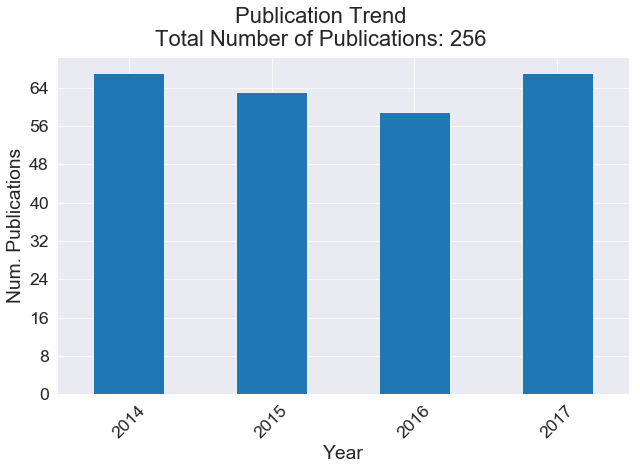

In [15]:
# Plotting out the publication trend. 
wos_plot.plot_pub_trend(filtered_corpora, title='Publication Trend', save_plot_fn=False)

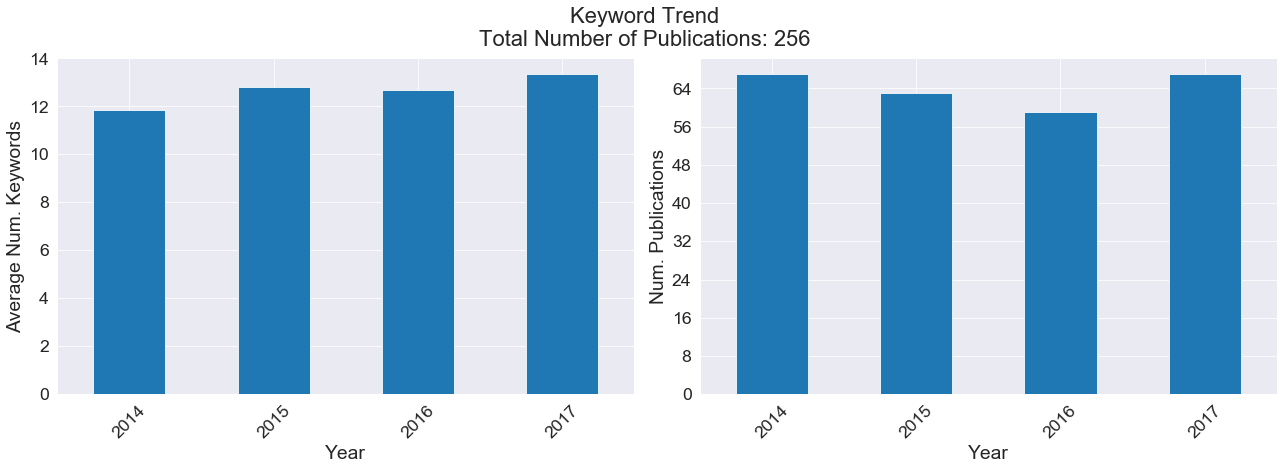

In [16]:
# Plot out the keyword trend
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=False)

You can also sort the publications into specific criterias.

This matches similar words as found in the title, abstract, and keyword sections.

In [17]:
# Keyword types adapted from Zare et al. (2017)
# http://dx.doi.org/10.1016/j.jhydrol.2017.07.031

criteria = {
    'overarching': set(['uncertainty', 'adapt', 'decision support', 'management', 'gis']),
    'agri': set(['agricultur', 'farm']),
    'water': set(['hydrology', 'water', 'stream', 'aquifer']),
    'enviro': set(['environment', 'climate', 'ecology', 'ecosystem', 'biodivers']),
    'socio_economic': set(['ecosystem service', 'social', 'conflict', 'particip', 'law', 'stakehold', 'policy', 'economic'])
}

crit_matches, crit_summary = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

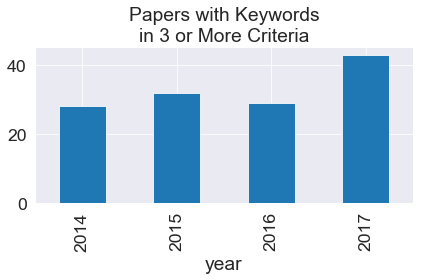

In [18]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=3)

Remember, you can look at the documentation for anything with the question mark magic command

In [19]:
?wos_plot.plot_criteria_trend

If desired, you can search the publications for a specific keyword (or list of keywords).

Here, we look for some keywords related to the field costs - anything that is 95% similar to the given keywords is acceptable.

In [20]:
matching_records, summary = keyword_matches(filtered_corpora, ['finance', 'costs', 'capita', 'monetary'], threshold=95.0)

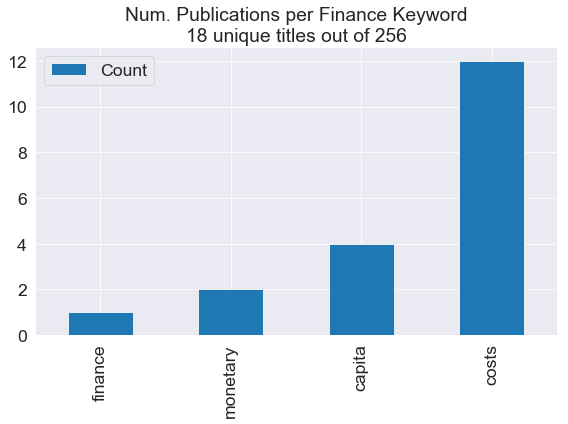

In [21]:
wos_plot.plot_pub_per_kw(matching_records, summary, filtered_corpora, kw_category='Finance')

We can then attempt to find topics of interest

In [22]:
topic_results = wosis.find_topics(filtered_corpora, num_topics=10)

Topic 1: water river management supply basin resources use quality modeling demand
Topic 2: model modelling models environmental modeling data management framework analysis processes
Topic 3: urban modelling infrastructure water planning drainage systems stormwater tools new
Topic 4: climate change future impacts scenarios changes vulnerability population agricultural hydrological
Topic 5: flood flash rainfall hydrological catchment runoff floods occurrence river events
Topic 6: air traffic pollution emissions emission quality pollutants dispersion stormwater modelling
Topic 7: groundwater flow surface recharge model aquifer low storage large water
Topic 8: energy transport carbon modeling electricity emissions generation nexus planning buildings
Topic 9: land use change soil erosion farm aquatic sediment changes scenarios
Topic 10: irrigation crop stochastic production agricultural demand yield million yields productivity


If the identified topics are too vague or not of interest, try increasing the number of topics. Conversely, if they are too specific, try lowering the number of topics.

Say we're interested in Topic 2. The cell below shows how to get the publications for this topic.

In [23]:
id_of_interesting_topic = 2
topic_set = topic_results.get_topic_by_id(id_of_interesting_topic)

In [24]:
print("Number of publications in topic set:", len(topic_set))

Number of publications in topic set: 111


In [25]:
# The publication set of interest!
# Hiding keywords and abstract for tutorial (WoS-owned IP)
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)  # show first 10

,year,title,AU,SO
1,2016,Processes and Modeling of Initial Soil and Lan...,"Maurer, Thomas|Gerke, Horst H.",VADOSE ZONE JOURNAL
3,2017,Valuing investments in sustainable land manage...,"Vogl, Adrian L.|Bryant, Benjamin P.|Hunink, Jo...",JOURNAL OF ENVIRONMENTAL MANAGEMENT
11,2017,Modeling land suitability for Coffea arabica L...,"Estrada, Leonel Lara|Rasche, Livia|Schneider, ...",ENVIRONMENTAL MODELLING & SOFTWARE
15,2015,Evaluating acceptability of groundwater protec...,"Giordano, Raffaele|D'Agostino, Daniela|Apollon...",AGRICULTURAL WATER MANAGEMENT
17,2015,Grid-wide subdaily hydrologic alteration under...,"Haas, J.|Olivares, M. A.|Palma-Behnke, R.",JOURNAL OF ENVIRONMENTAL MANAGEMENT
18,2014,Systematic assessment of the uncertainty in in...,"Wu, Bin|Zheng, Yi|Tian, Yong|Wu, Xin|Yao, Ying...",WATER RESOURCES RESEARCH
19,2016,Non-hazardous pesticide concentrations in surf...,"Bannwarth, M. A.|Grovermann, C.|Schreinemacher...",JOURNAL OF ENVIRONMENTAL MANAGEMENT
21,2017,Integrated modelling with environmental parame...,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT
23,2014,Risk-Optimized Design of Production Systems by...,"Luetjen, Michael|Alla, Abderrahim Ait",MATHEMATICAL PROBLEMS IN ENGINEERING
24,2017,Integrated Modeling of Survival Data from Mult...,"Proctor, Abigael H.|King, Catherine K.|Holan, ...",ENVIRONMENTAL SCIENCE & TECHNOLOGY


Lets extract the records of interest from the original record collection and do some analysis

In [26]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

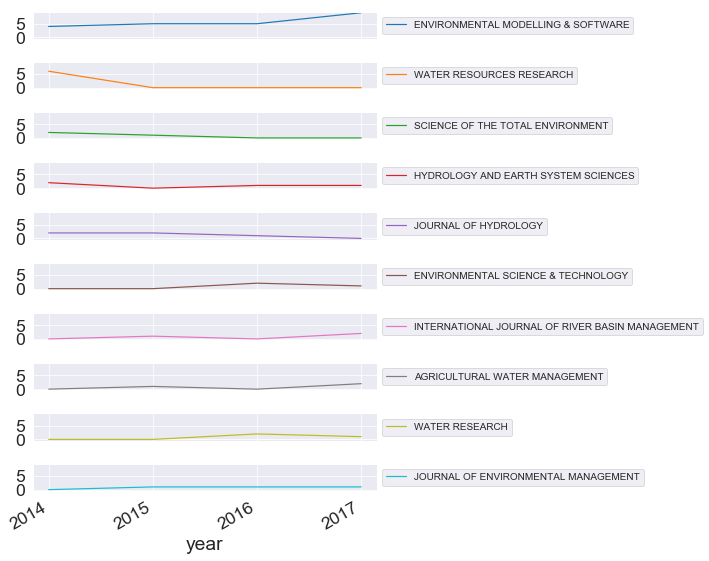

In [27]:
# The publication trend per journal
wos_plot.plot_journal_pub_trend(topic_recs)

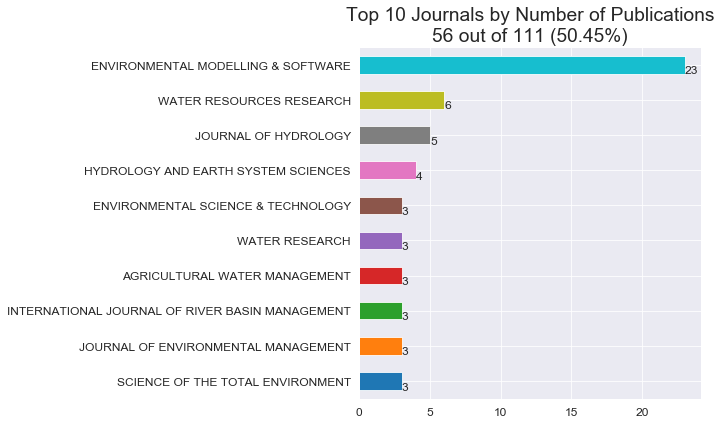

In [28]:
# The overall number of publications for each journal
wos_plot.plot_pubs_per_journal(topic_recs, top_n=10, annotate=True, show_stats=True)

In [29]:
# Papers cited by the corpora 
# NOTE: This does NOT identify which the paper in the collection with the most citations
# It identifies the papers that the corpora cites the most.
wosis.analysis.pub_citations(topic_recs)[0:5]

,Citations
Publication,
"Voinov, Alexey, 2008, Lessons for successful participatory watershed modeling: A perspective from modeling practitioners, ECOLOGICAL MODELLING, 216, 197, 91230070",26
"Jakeman, AJ, 2006, Ten iterative steps in development and evaluation of environmental models, ENVIRONMENTAL MODELLING & SOFTWARE, 21, 602, 66585814",20
"Laniak, Gerard F., 2013, Integrated environmental modeling: A vision and roadmap for the future, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 3, 442976548",20
"Castronova, Anthony M., 2013, Integrated modeling within a Hydrologic Information System: An OpenMI based approach, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 263, 434864554",16
"Argent, RM, 2004, An overview of model integration for environmental application - components, frameworks and semantics, ENVIRONMENTAL MODELLING & SOFTWARE, 19, 219, 495524493",14


In [30]:
# To get the citations for each paper in the collection, we have send another request to WoS
topic_cites = wosis.get_num_citations(topic_recs, wos_config)

Authenticated (SID: 5Bs76IMDQesD4t8DLeU)


100%|████████████████████████████████████████████████████████████████████████████| 111/111 [01:34<00:00,  1.25it/s]


In [31]:
topic_cites[['AU', 'title', 'citations']].head()

,AU,title,citations
25,"Costanza, Robert|de Groot, Rudolf|Braat, Leon|...",Twenty years of ecosystem services: How far ha...,100
98,"Hamilton, Serena H.|ElSawah, Sondoss|Guillaume...",Integrated assessment and modelling: Overview ...,73
108,"Macmillan, Alexandra|Connor, Jennie|Witten, Ka...",The Societal Costs and Benefits of Commuter Bi...,58
5,"Wu, Bin|Zheng, Yi|Tian, Yong|Wu, Xin|Yao, Ying...",Systematic assessment of the uncertainty in in...,37
80,"Reis, Stefan|Seto, Edmund|Northcross, Amanda|Q...",Integrating modelling and smart sensors for en...,34


In [32]:
# Authors in the corpora with the most citations (careful interpreting this - author names are grouped by surname so it is misleading)
wosis.analysis.author_citations(topic_recs)[0:10]

,Citations
Publication,
Liu,36
Zhang,32
Voinov,31
Wang,31
Li,30
Arnold,22
Jakeman,21
Laniak,20
Wu,20


Wosis can also help create links to the publications where possible

In [33]:
topic_df = wosis.link_to_pub(topic_recs)  # Creates a new column called 'DOI link'
topic_df.loc[:, ~topic_df.columns.isin(hide_columns)].head(10)

,year,title,AU,SO,DOI link
0,2016,Processes and Modeling of Initial Soil and Lan...,"Maurer, Thomas|Gerke, Horst H.",VADOSE ZONE JOURNAL,https://dx.doi.org/10.2136/vzj2016.05.0048
1,2017,Valuing investments in sustainable land manage...,"Vogl, Adrian L.|Bryant, Benjamin P.|Hunink, Jo...",JOURNAL OF ENVIRONMENTAL MANAGEMENT,https://dx.doi.org/10.1016/j.jenvman.2016.10.013
2,2017,Modeling land suitability for Coffea arabica L...,"Estrada, Leonel Lara|Rasche, Livia|Schneider, ...",ENVIRONMENTAL MODELLING & SOFTWARE,https://dx.doi.org/10.1016/j.envsoft.2017.06.028
3,2015,Evaluating acceptability of groundwater protec...,"Giordano, Raffaele|D'Agostino, Daniela|Apollon...",AGRICULTURAL WATER MANAGEMENT,https://dx.doi.org/10.1016/j.agwat.2014.07.023
4,2015,Grid-wide subdaily hydrologic alteration under...,"Haas, J.|Olivares, M. A.|Palma-Behnke, R.",JOURNAL OF ENVIRONMENTAL MANAGEMENT,https://dx.doi.org/10.1016/j.jenvman.2015.02.017
5,2014,Systematic assessment of the uncertainty in in...,"Wu, Bin|Zheng, Yi|Tian, Yong|Wu, Xin|Yao, Ying...",WATER RESOURCES RESEARCH,https://dx.doi.org/10.1002/2014WR015366
6,2016,Non-hazardous pesticide concentrations in surf...,"Bannwarth, M. A.|Grovermann, C.|Schreinemacher...",JOURNAL OF ENVIRONMENTAL MANAGEMENT,https://dx.doi.org/10.1016/j.jenvman.2014.12.001
7,2017,Integrated modelling with environmental parame...,"Sheykhi, Vahideh|Moore, Farid|Kavousi-Fard, Ab...",INTERNATIONAL JOURNAL OF RIVER BASIN MANAGEMENT,https://dx.doi.org/10.1080/15715124.2017.1300158
8,2014,Risk-Optimized Design of Production Systems by...,"Luetjen, Michael|Alla, Abderrahim Ait",MATHEMATICAL PROBLEMS IN ENGINEERING,https://dx.doi.org/10.1155/2014/934176
9,2017,Integrated Modeling of Survival Data from Mult...,"Proctor, Abigael H.|King, Catherine K.|Holan, ...",ENVIRONMENTAL SCIENCE & TECHNOLOGY,https://dx.doi.org/10.1021/acs.est.7b02255


Other analysis can easily be accomplished with Pandas